**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1188DQBNnxXgxxZoldO8cXiQFYaO9PoOh?usp=sharing)

2. [Практический ноутбук 1](https://colab.research.google.com/drive/1EcHhwOCIhvm4mpxEbDGRawIJ4BpbAyqO?usp=sharing)

3. [Практический ноутбук 2](https://colab.research.google.com/drive/1pHONL5J4AVraE-SYJnpes7KdicPsD9qt?usp=sharing)

3. Практический ноутбук 3


В финальном ноутбуке занятия мы создадим сегментриующую модель на базе изображений самолетов. Эта задача значительно проще предыдущей, поскольку на оригинальном изображении будет всего два класса объектов:
- самолет
- фон

## Подключение бибилиотек


In [ ]:
# Основа для модели нейронной сети
from tensorflow.keras.models import Model 

# Стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization 

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# Дополнительные утилиты keras
from tensorflow.keras import utils 

# Инструменты для построения графиков
import matplotlib.pyplot as plt 

# Инструменты для работы с изображениями
from tensorflow.keras.preprocessing import image 

# Инструменты для работы с массивами
import numpy as np 

# Системные инструменты
import time, random, gdown, os

# Дополнительные инструменты для работы с изображениями
from PIL import Image 

# Дополнительные инструменты визуализации
import seaborn as sns
sns.set_style('darkgrid')

## Загрузка датасета

По аналогии с базой "Стройка" подготовим необходимые данные для обучения сети для базы "Самолеты"

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/airplane_456x256.zip', None, quiet=True)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/airplane_912x512.zip', None, quiet=True)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/airplane_1920x1080.zip', None, quiet=True)

'airplane_456x256.zip'

In [ ]:
# Распаковка архива

!unzip -qo airplane_456x256.zip

Для данного занятия возьмем уменьшенный размер изображений (**456x256** пикселей). При наличии достаточных вычислительных мощностей вы можете воспользоваться базой с бОльшим разрешением.

In [ ]:
# Глобальные параметры

IMG_WIDTH = 256               # Ширина картинки 
IMG_HEIGHT = 456              # Высота картинки 
CLASS_COUNT = 2               # Количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

In [ ]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')): 

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))               
        
    # Вывод времени загрузки картинок выборки    
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title, 
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list)) 

    return image_list

In [ ]:
# Функция для просмотра изображений из набора

def show_imageset(image_list,  # выборка изображений
                  n            # количество картинок для просмотра
                  ):

    fig, axs = plt.subplots(1, n, figsize=(25, 10))       # Создание полотна из n графиков

    # Вывод в цикле n случайных изображений
    for i in range(n): 
        img = random.choice(image_list)                   # Выборка случайного фото для отображения
        axs[i].axis('off')
        axs[i].imshow(img)                                # Отображение картинки

    plt.show()                                            # Отрисовка изображений

In [ ]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.43 с
Количество изображений: 931
Проверочная выборка загружена. Время загрузки: 0.02 с
Количество изображений: 50


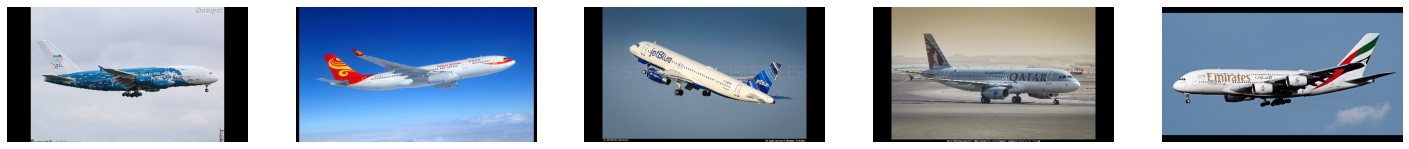

In [ ]:
# Просмотр входных изображений из обучающего набора

show_imageset(train_images, 5)

In [ ]:
# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.30 с
Количество изображений: 931
Проверочная выборка загружена. Время загрузки: 0.02 с
Количество изображений: 50


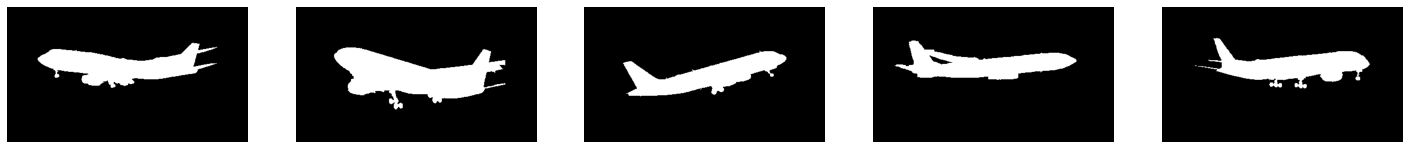

In [ ]:
# Просмотр сегментированных изображений из обучающего набора

show_imageset(train_segments, 5)

In [ ]:
# Цвета пикселов сегментированных изображений

AIRPLANE = (255, 255, 255)      # Самолет (белый)
BACKGROUND = (0, 0, 0)          # Фон (черный)

In [ ]:
CLASS_LABELS = (AIRPLANE, BACKGROUND)

## Создание выборки

Переведем сегментированные изображения в одноканальные сегментированные с номером класса в каждом пикселе (функции из практики №1):

In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений 
                 ):

    result = []
  
    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS): 
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i 

        result.append(y)
  
    return np.array(result)

Обратная функция, перевод одноканальных сегментированных изображений с номером класса в каждом пикселе в 3х канальное RGB сегментированное изображение:

In [ ]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений 
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)
  
    return np.array(result)

Сформируем выборки:

In [ ]:
# Формирование обучающей выборки

x_train = []                          # Cписок под обучающую выборку

for img in train_images:              # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_train.append(x)                 # Добавление элемента в x_train

x_train = np.array(x_train)           # Перевод всей выборки в numpy
print(x_train.shape)                  # Форма x_train

(931, 256, 456, 3)


In [ ]:
# Формирование проверочной выборки

x_val = []                            # Cписок под проверочную выборку

for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)                    # Форма x_train

(50, 256, 456, 3)


In [ ]:
# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(931, 256, 456, 1)
(50, 256, 456, 1)


## Простая линейная (последовательная) архитектура

Для начала попробуем простую линейную модель:

In [ ]:
def sequential_segmentation_net(class_count,  # количество классов
                                input_shape   # форма входного изображения
                                ):

    img_input = Input(input_shape)                                              # Создаем входной слой формой input_shape
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)   

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv3')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv4')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)     

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv5')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)           
       
    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)    # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                                 # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    # Возвращаем сформированную модель
    return model 

In [ ]:
# Создание модели и вывод сводки по архитектуре

model_seq = sequential_segmentation_net(CLASS_COUNT,
                                       (IMG_WIDTH, IMG_HEIGHT, 3))

model_seq.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 456, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 456, 128)     3584      
                                                                 
 batch_normalization_4 (Batc  (None, 256, 456, 128)    512       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 256, 456, 128)     0         
                                                                 
 block1_conv3 (Conv2D)       (None, 256, 456, 64)      73792     
                                                                 
 batch_normalization_5 (Batc  (None, 256, 456, 64)     256       
 hNormalization)                                           

In [ ]:
# Обучение модели

history = model_seq.fit(x_train, y_train,
                        epochs=50, batch_size=32,
                        validation_data=(x_val, y_val))

Epoch 1/50
30/30 [==============================] - 14s 460ms/step - loss: 0.3350 - sparse_categorical_accuracy: 0.9070 - val_loss: 0.9132 - val_sparse_categorical_accuracy: 0.3676
Epoch 2/50
30/30 [==============================] - 14s 454ms/step - loss: 0.2350 - sparse_categorical_accuracy: 0.9365 - val_loss: 0.5141 - val_sparse_categorical_accuracy: 0.7640
Epoch 3/50
30/30 [==============================] - 14s 453ms/step - loss: 0.1970 - sparse_categorical_accuracy: 0.9443 - val_loss: 0.4059 - val_sparse_categorical_accuracy: 0.8805
Epoch 4/50
30/30 [==============================] - 14s 454ms/step - loss: 0.1742 - sparse_categorical_accuracy: 0.9493 - val_loss: 0.3702 - val_sparse_categorical_accuracy: 0.8646
Epoch 5/50
30/30 [==============================] - 14s 455ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.9524 - val_loss: 0.2894 - val_sparse_categorical_accuracy: 0.9028
Epoch 6/50
30/30 [==============================] - 14s 454ms/step - loss: 0.1439 - sparse_cate

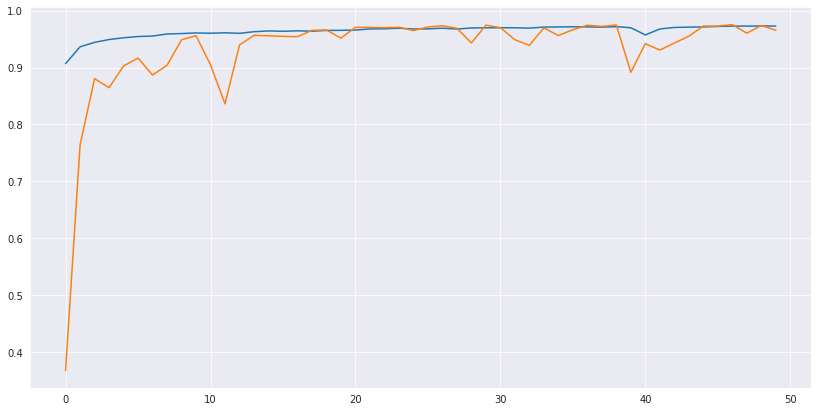

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

Мы получили довольно неплохие результаты. **0.97** - очень хороший показатель для проверочной выборки.

Теперь взглянем на результат работы нашей модели:

In [ ]:
# Функция визуализации процесса сегментации изображений, модифицированная для вывода по списку индексов

def process_images(model,                       # обученная модель
                   count=1,                     # количество случайных картинок для сегментации
                   indexes=None,                # список индексов изображений в проверочной выборке
                   ):
  
    if indexes is None:
        # Генерация случайного списка индексов в количестве count между (0, len(x_val)
        indexes = np.random.randint(0, len(x_val), count)
    else:
        count = len(indexes)

    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 10)) 
    
    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show() 

**Распознавание**

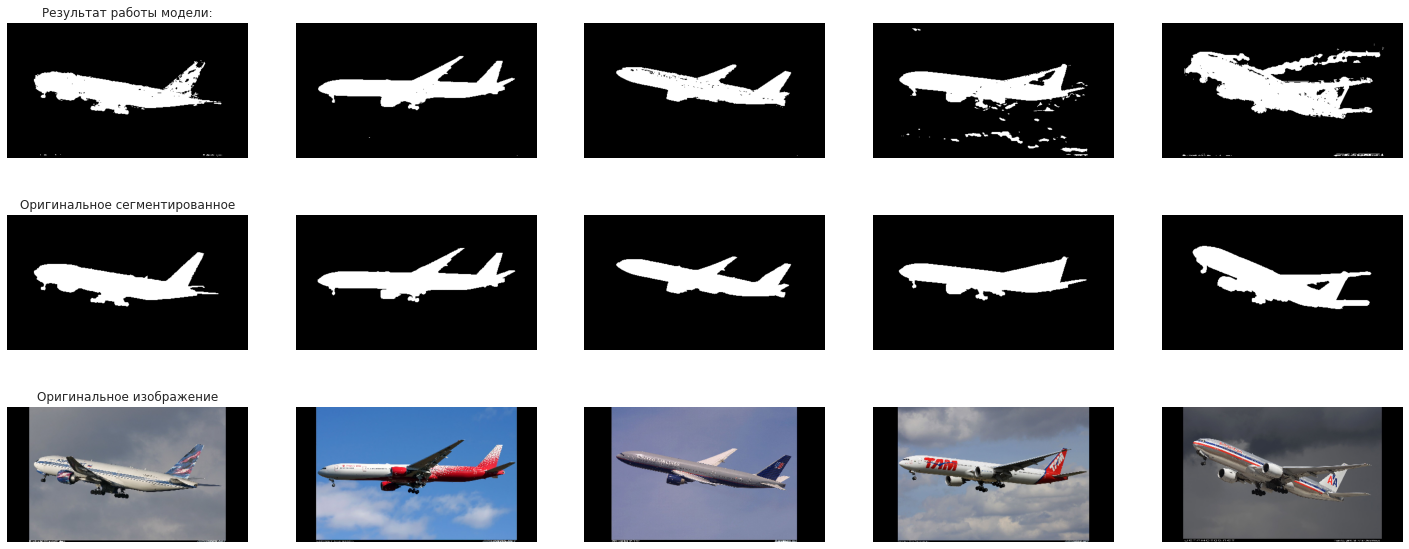

In [ ]:
# Отображение результатов работы модели

process_images(model_seq, 5)

Очень даже неплохо! Теперь мы вправе расчитывать, что получим отличные результаты с более мощной архитектурой, например, **U-Net**.

## Архитектура U-Net

In [ ]:
def unet(class_count,   # количество классов
         input_shape    # форма входного изображения
         ): 
  
    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # Возвращаем сформированную модель
    return model

In [ ]:
# Создание модели и вывод сводки по архитектуре

model_unet = unet(CLASS_COUNT, 
                  (IMG_WIDTH, IMG_HEIGHT, 3))

model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 456, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 456, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 456, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 456, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Обучение модели

history = model_unet.fit(x_train, y_train, 
                         epochs=50, batch_size=12,
                         validation_data=(x_val, y_val)) 

Epoch 1/50
78/78 [==============================] - 67s 604ms/step - loss: 0.1393 - sparse_categorical_accuracy: 0.9584 - val_loss: 0.2807 - val_sparse_categorical_accuracy: 0.8886
Epoch 2/50
78/78 [==============================] - 44s 565ms/step - loss: 0.0448 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.3109 - val_sparse_categorical_accuracy: 0.8796
Epoch 3/50
78/78 [==============================] - 44s 565ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.2005 - val_sparse_categorical_accuracy: 0.9060
Epoch 4/50
78/78 [==============================] - 44s 565ms/step - loss: 0.0276 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.0681 - val_sparse_categorical_accuracy: 0.9744
Epoch 5/50
78/78 [==============================] - 44s 565ms/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9925 - val_loss: 0.0322 - val_sparse_categorical_accuracy: 0.9894
Epoch 6/50
78/78 [==============================] - 44s 565ms/step - loss: 0.0221 - sparse_cate

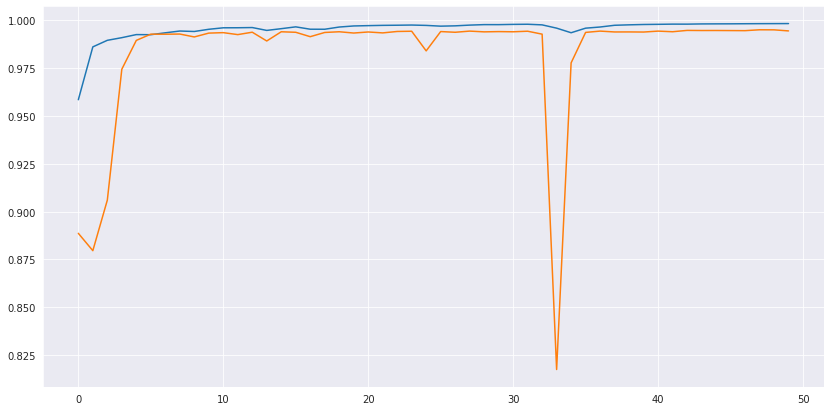

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

**Распознавание**

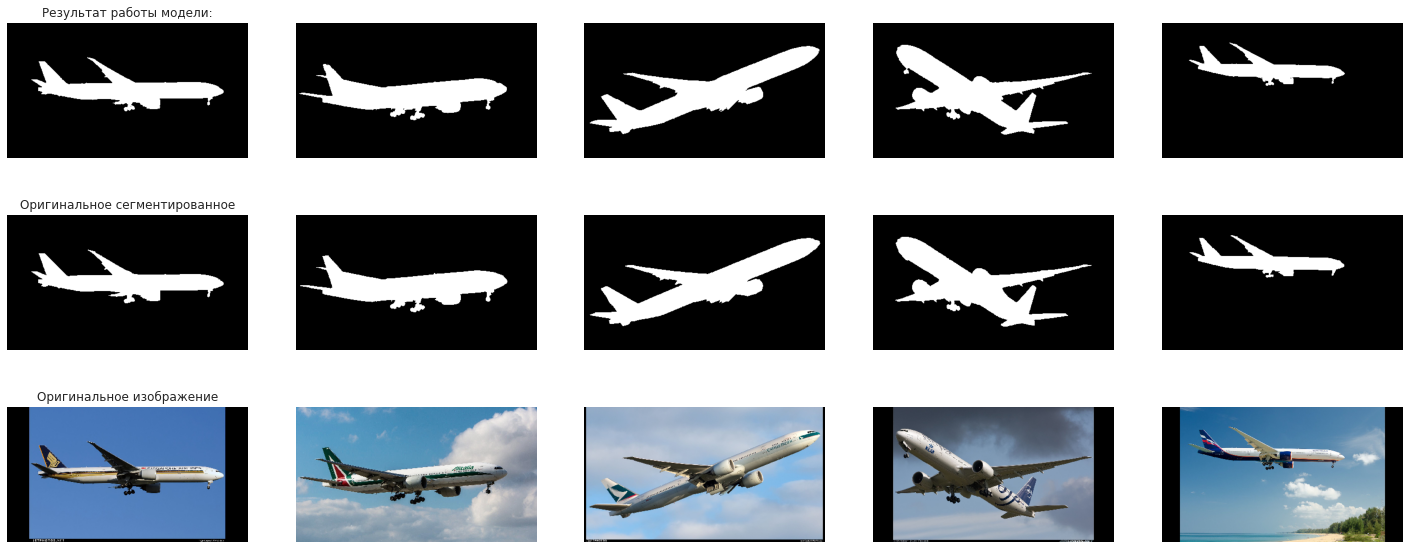

In [ ]:
# Отображение результатов работы модели

process_images(model_unet, 5)

Полученный результат выглядит очень мощно! Модель сегментирует даже самые мелкие детали.

Теперь выведем **5** самых плохих по точности изображений проверочной выборки:

In [ ]:
# Получение массива значений функции ошибки для каждого изображения из проверочной выборки

accuracy = np.array([model_unet.evaluate(x_val[i:i+1], 
                                         y_val[i:i+1],
                                         verbose=0)[1] for i in range(x_val.shape[0])])

print(accuracy)

[0.99739581 0.99642783 0.99426055 0.9952457  0.99705321 0.99464601
 0.99560547 0.99642783 0.99213612 0.9972074  0.99869794 0.99594814
 0.99881786 0.99814969 0.97253633 0.99764425 0.99735302 0.99581105
 0.9952628  0.99689901 0.99771279 0.99814111 0.99506581 0.9970789
 0.99605948 0.99895489 0.99719024 0.99487734 0.94459295 0.99817538
 0.99770421 0.99836385 0.99635077 0.98385245 0.99652207 0.98475194
 0.99695897 0.99650496 0.99675333 0.99726737 0.99477452 0.99811542
 0.99758428 0.99568254 0.99418348 0.99722451 0.99665058 0.98673934
 0.99382365 0.99834669]


Мы получили массив **accuracy**, в котором сохранены значения **val_sparse_categorical_accuracy** для каждого изображения проверочной выборки. Выберем отсюда **5** худших значений:

In [ ]:
# Получение индексов самых плохих по точности сегментации изображений

print('5 худших по точности сегментации изображений')
bad = np.argsort(accuracy)[:5].tolist()

for b in bad:
    print(f'Изображение №{b} - точность: {accuracy[b]}')

5 худших по точности сегментации изображений
Изображение №28 - точность: 0.9445929527282715
Изображение №14 - точность: 0.9725363254547119
Изображение №33 - точность: 0.9838524460792542
Изображение №35 - точность: 0.9847519397735596
Изображение №47 - точность: 0.9867393374443054


Выведем на экран результаты работы модели на этих изображениях:

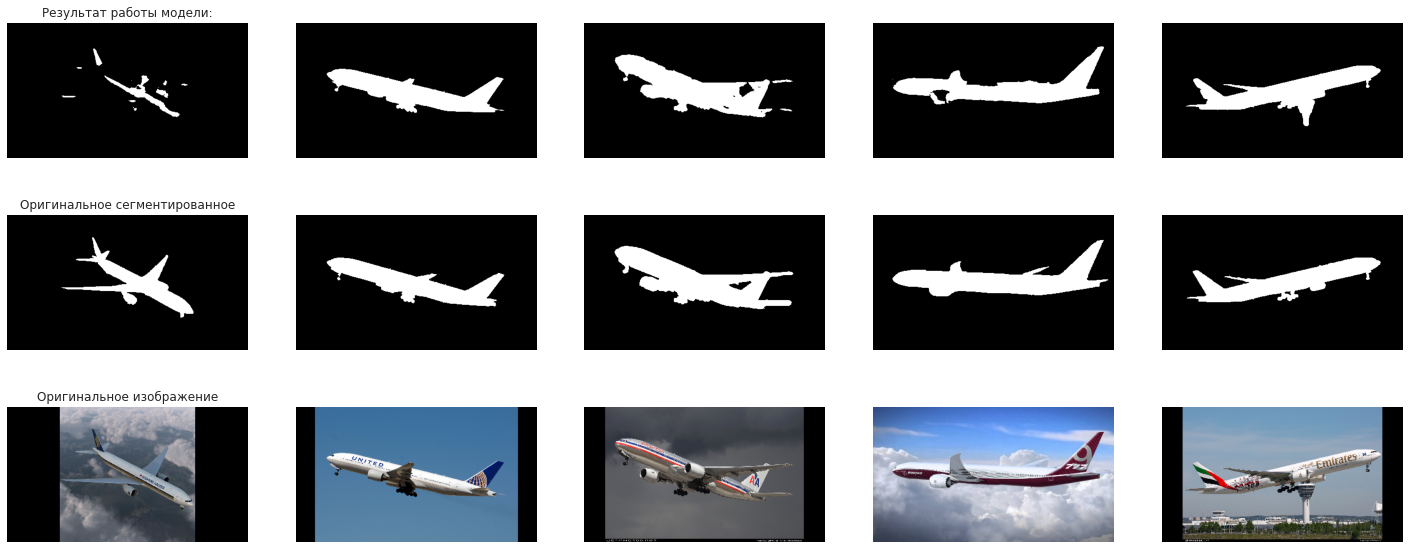

In [ ]:
# Вывод 5 изображений проверочной выборки, на которых модель дает наихудшие результаты

process_images(model_unet, indexes=bad)

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1188DQBNnxXgxxZoldO8cXiQFYaO9PoOh?usp=sharing)

2. [Практический ноутбук 1](https://colab.research.google.com/drive/1EcHhwOCIhvm4mpxEbDGRawIJ4BpbAyqO?usp=sharing)

3. [Практический ноутбук 2](https://colab.research.google.com/drive/1pHONL5J4AVraE-SYJnpes7KdicPsD9qt?usp=sharing)

3. Практический ноутбук 3
